# Estimating depth from 2 images
As you probably already know, a single image is not sufficient to determine the distance of any object in the scene to the camera. If you were shown an image and asked to determine the depths of every object, you'd be able to make a (probably correct) guess about how far each thing is away from you by exploiting prior knowledge of the scene, sizes of objects, placement of shadows, etc, but a computer cannot easily use the same priors.

However, adding a second image of the same scene taken from a different viewpoint changes the problem. We know that objects closer to us "move" quite a bit when we switch eyes, while ones farther away move very little. Have a look at the following images to confirm this.

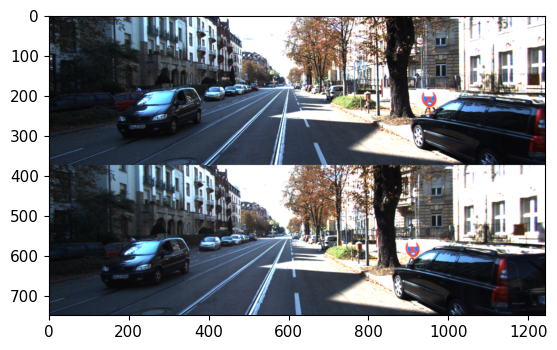

In [11]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt

# These images are from the KITTI computer vision dataset
left_img = cv2.imread('imgs/2_000000_10.png')
right_img = cv2.imread('imgs/3_000000_10.png')

CAM_WIDTH = 0.54 # meters between cameras
CAM_HEIGHT = 1.65 # meters above ground

# btw, opencv's uses BGR and matplotlib uses RGB, so unless you convert
# before plotting your colors are swapped
plt.imshow(
    cv2.vconcat(
        (cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB),
         cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB))
    )
)

Let's try to plug those two images into the stereo block matching algorithm.

In [12]:
# You'll find that some of the more complicated algos have a `_create` function associated with them.
# These objects typically do not work at all if constructed the usual way, so you must use their _create.
stereo = cv2.StereoBM_create(64, 15) # The second arg, window size, must be an odd number.

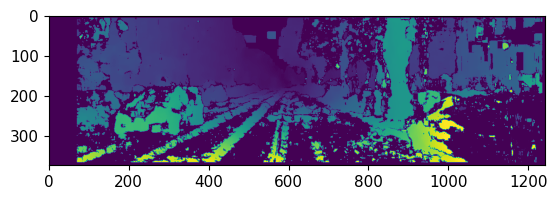

In [13]:
l_gray = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
r_gray = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)
disparity_map = stereo.compute(l_gray, r_gray)
plt.imshow(disparity_map)

What do you observe about this image? More yellow means closer, more navy is farther.
Here are a few of my thoughts...
* Areas with no contrast such as the road or sky, don't have useful depth information
* Strong, small features like the road stripe, or well lit from of the rightmost car have smooth depth information

Using the cell below, try a few filters on the image to get a "better" depth map. Maybe sharpening, or improving the image contrast will help. There are also other stereo block matching algorithms in OpenCV so you could also dig in to the documentation to see if any of the other implementations produces better results.

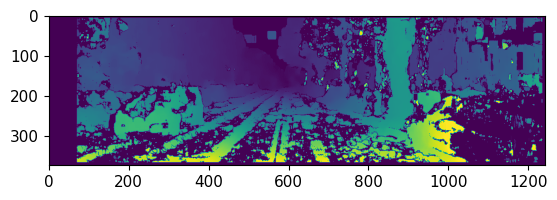

In [14]:
import numpy as np

# Let's try blurring the image just to see if it does anything...
# Add your filters in this cell.
sharpf = np.array([[1, 1, 1],
                   [1, 1, 1],
                   [1, 1, 1]]) / 9

l_sharp = cv2.filter2D(l_gray, -1, sharpf)
r_sharp = cv2.filter2D(r_gray, -1, sharpf)
disparity_map = stereo.compute(l_sharp, r_sharp)
plt.imshow(disparity_map)

In [15]:
# TODO some writeup about how to take our own stereo dataset and validate distances

Next, here are some images prepared by running the images through YoloV5, a state of the art object detection network. Conveniently, "car" is one of its pretrained object classes, so the pretrained model detects multiple boxes in our image. We could then combine the depth map with the bounding box information to estimate the distance to each object, provided there's a nice correlation between depth map value and real world units like meters.

Another thing we could try is to find the stereo disparities of specific bounding boxes

In [17]:
# See https://pytorch.org/hub/ultralytics_yolov5/ for dependency install
!pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

Using cache found in C:\Users\krmfl/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-10-14 Python-3.9.13 torch-1.12.1+cu116 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 


         xmin        ymin         xmax        ymax  confidence  class    name
0  169.509216  178.889236   390.587799  302.076294    0.900875      2     car
1  910.996094  185.719391  1237.715698  369.004059    0.865777      2     car
2  387.863098  176.394760   444.922913  212.384842    0.563943      2     car
3  905.966370  185.574188  1009.088440  253.364532    0.461924      2     car
4  455.046082  172.155365   501.576294  199.218460    0.337001      2     car
5  267.758118  126.217468   308.453430  177.969315    0.280393      0  person


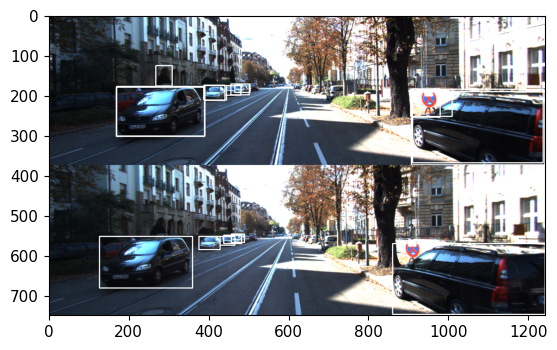

In [21]:
import torch 
model = torch.hub.load('ultralytics/yolov5', 'yolov5n', pretrained=True, trust_repo=True)

# Images
imgs = [left_img, right_img]

# Inference
results = model(imgs)

# Results
print(results.pandas().xyxy[0])  # img1 predictions (pandas)

def draw_boxes(img, preds):
    for idx, box in preds.iterrows():
        cv2.rectangle(
            img,
            np.array((box['xmin'], box['ymin']), dtype=np.int32),
            np.array((box['xmax'], box['ymax']), dtype=np.int32),
            (255,255,255),
            2,
        )
        
    return img
        

leftboxes = draw_boxes(
    cv2.cvtColor(imgs[0], cv2.COLOR_BGR2RGB),
    results.pandas().xyxy[0]
)

rightboxes = draw_boxes(
    cv2.cvtColor(imgs[1], cv2.COLOR_BGR2RGB),
    results.pandas().xyxy[1]
)

plt.imshow(cv2.vconcat((leftboxes,rightboxes)))

Another thing we could try is to find the stereo disparities of specific bounding boxes. Running both of the earlier images through yolov5, an object detection CNN, yields the bounding boxes and labels seen in the following images.

Here are the positions of all the bounding boxes found in the left and right images. Now we have to determine which boxes in the left image correspond to boxes in the right image, as well as ignore any matches that don't appear in both images. Visually, this is self evident, but how can we do it programmatically?

Simply checking the position is a good first guess so let's try that now. The indexing syntax for the result might look a bit odd to you here. It's stored in a `pandas` dataframe, not a numpy or torch array, so you might need mess around with it a bit to understand its access functions.

In [10]:
import math
left, right = results.pandas().xyxy

# Functions on boxes using the information stored in their rows
def area(box_row):
    return (box_row['xmax'] - box_row['xmin']) * (box_row['ymax'] - box_row['ymin'])

def midpoint(box_row):
    return (box_row['xmax'] + box_row['xmin']) // 2, (box_row['ymax'] + box_row['ymin']) // 2

def distance(box0_row, box1_row):
    mid0 = midpoint(box0_row)
    mid1 = midpoint(box1_row)
    
    return np.sqrt((mid0[0] - mid1[0])**2 + (mid0[1] - mid1[1])**2)

def compare(box0_row, box1_row):
    return np.abs(area(box0_row) - area(box1_row)), distance(box0_row, box1_row)


for lidx, lrow in left.iterrows():
    best_idx = -1
    best_dist = 5000
    for ridx, rrow in right.iterrows():
        diff_area, distance = compare(lrow, rrow)
        print(diff_area)
        print(distance)

3071.86982712138
37.013511046643494


TypeError: 'numpy.float64' object is not callable

The results from checking absolute position alone aren't bad, but you can probably see that some of the cars get pretty close together and are about the same size. It may also be worth rejecting all detections below some confidence threshold. Removing all boxes under <60% confidence would clean up our results. 